In [2]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels, temporal_lobe_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


In [3]:
# sub lists I've been using to explore FR1 

# subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[5:]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
18,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,1,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
25,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...,protocols/r1/subjects/R1006P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1006P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1006P/localizations/0/m...,NaN,0,R1006P,R1006P,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...
26,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...,protocols/r1/subjects/R1006P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1006P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1006P/localizations/0/m...,NaN,1,R1006P,R1006P,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...
37,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,0,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...
38,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,1,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...
639,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,0,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...
640,NaN,protocols/r1/subjects/R1112M/experiments/FR1/s...,protocols/r1/subjects/R1112M/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1112M/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1112M/localizations/0/m...,NaN,1,R1112M,R1112M,1.0,protocols/r1/subjects/R1112M/experiments/FR1/s...


In [4]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[-19:]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(565, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,NaN,protocols/r1/subjects/R1565T/experiments/FR1/s...,protocols/r1/subjects/R1565T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1565T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1565T/localizations/0/m...,NaN,0,R1565T,R1565T,1.0,protocols/r1/subjects/R1565T/experiments/FR1/s...
2540,NaN,protocols/r1/subjects/R1569T/experiments/FR1/s...,protocols/r1/subjects/R1569T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1569T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1569T/localizations/0/m...,NaN,0,R1569T,R1569T,1.0,protocols/r1/subjects/R1569T/experiments/FR1/s...
2545,NaN,protocols/r1/subjects/R1571T/experiments/FR1/s...,protocols/r1/subjects/R1571T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1571T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1571T/localizations/0/m...,NaN,0,R1571T,R1571T,1.0,protocols/r1/subjects/R1571T/experiments/FR1/s...
2549,NaN,protocols/r1/subjects/R1572T/experiments/FR1/s...,protocols/r1/subjects/R1572T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1572T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1572T/localizations/0/m...,NaN,0,R1572T,R1572T,1.0,protocols/r1/subjects/R1572T/experiments/FR1/s...


In [5]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'surrounding_recall'
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
#               NOTE: this analysis is in SWRanalysis-encoding.ipynb now
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

recall_type_switch = 0
    # (1 and 3 are basically opposites...those with a subsequent recall and those without)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolatead recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period (opposite of 4)
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 8: take only 2nd recalls
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'TEMPORALLOBE' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # TEMPORALLOBE
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in sub_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            elif selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
            elif selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array'])
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                rectime_array.extend(dat['rectime_array'])
                recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])
            elif selected_period == 'whole_encoding':
                serialpos_array.extend(dat['serialpos_array']); recall_position_array.extend(dat['recall_position_array'])
                list_recall_num_array.extend(dat['list_recall_num_array']); 

            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>=0
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
    temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
    encoded_word_key_array.extend(dat['encoded_word_key_array'])
elif selected_period == 'whole_encoding':
    temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
session_name_array = np.array(session_name_array)[temp_recall_idxs]
electrode_array = np.array(electrode_array)[temp_recall_idxs]
channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
ripple_array = np.array(ripple_array)[temp_recall_idxs]
rectime_array = np.array(rectime_array)[temp_recall_idxs]
list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all HPC subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for FR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for FR1
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total electrodes: '+str(sum(region_electrode_ct)))
print('Length of HPC names: '+str(len(HPC_names)))
print('Total trials: '+str(np.sum(trial_nums)))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('Unique subjects: '+str(len(np.unique(sub_names))))

# some info about regions 
print('Total electrodes: '+str(len(HPC_names)))
unique_names = np.unique(HPC_names); print(unique_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
# channel_nums

[]
[]
**Done reading data**
**Done translating to ripple_array frame**!!
...
% of all HPC subjects for FR1


3.592814371257485

% of HPC recalls for FR1


23.0498038631511

(13926, 2000)

From 13/13 sessions with >0 TEMPORALLOBE electrodes
Total electrodes: 322
Length of HPC names: 322
Total trials: 13926.0
Unique sessions: 13
Unique subjects: 6
Total electrodes: 322
['entorhinal' 'fusiform' 'inferiortemporal' 'left amy' 'left ca1'
 'left ca3' 'left dg' 'left middle temporal gyrus'
 'left mtg middle temporal gyrus' 'left stg superior temporal gyrus'
 'middletemporal' 'parahippocampal' 'right amy' 'right ca1' 'right dg'
 'right hippocampus' 'right mtg middle temporal gyrus' 'right mtl wm'
 'right prc' 'right sub' 'superiortemporal' 'temporalpole']
3 for entorhinal
24 for fusiform
63 for inferiortemporal
10 for left amy
11 for left ca1
4 for left ca3
2 for left dg
2 for left middle temporal gyrus
1 for left mtg middle temporal gyrus
1 for left stg superior temporal gyrus
80 for middletemporal
7 for parahippocampal
12 for right amy
9 for right ca1
9 for right dg
3 for right hippocampus
3 for right mtg middle temporal gyrus
3 for right mtl wm
2 for right prc
4 for right sub

## To make a video I need a time-binned ripple rate matrix along with the 3D coordinates

In [7]:
spatial_bin = 1 # in mm. edge length of "voxel" that I'll average over for visualization
time_bin = 50 # in ms. Will average rate in this 50 ms bin

# already downsampled to 500 Hz SR and going to downsample by factor of time_bin
downsample_factor = int(time_bin/2)

binned_elec_ripple_array = []
elec_channel_coords = []

# iterate over electrodes within each subject since need a separate binned_ripple_array for each

for sub in np.unique(subject_name_array):

    for elec in np.unique(electrode_array[subject_name_array==sub]):
    
        # this is array for a single electrode (can be multiple sessions--not a problem!)
        elec_ripple_array = ripple_array[(subject_name_array==sub) & (electrode_array==elec)]
                
        # bin by downsampling and create elecs X time matrix for each subject
        binned_elec_ripple_array = superVstack(binned_elec_ripple_array,
                                    (1000/time_bin)*np.mean(downsampleBinary(elec_ripple_array,downsample_factor),0))
        
        elec_channel_coords.append(channel_coords_array[(subject_name_array==sub) & (electrode_array==elec)][0])
        
        

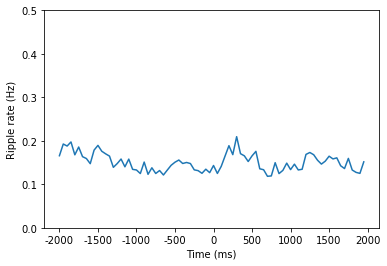

In [8]:
# to plot the binned array

plot(np.mean(binned_elec_ripple_array,0))
ylim(0,0.5)
xticks(np.arange(0,80.1,10),np.arange(-2000,2001,500))
ylabel('Ripple rate (Hz)')
xlabel('Time (ms)');

In [11]:
np.shape(binned_elec_ripple_array)
np.shape(elec_channel_coords)

(166, 80)

(166, 3)

## Now, we have to figure out how to deal with overlapping electrodes

In [12]:
spatial_bin = 5 # in mm

elec_coords_df = pd.DataFrame(elec_channel_coords, columns = ['x','y','z'])
# elec_coords_df = elec_coords_df.sort_values(['x', 'y', 'z'], ascending=[True, True,True])
print('Number of electrodes: '+str(len(elec_coords_df)))

voxel_RRs = []
voxel_coords = []

# now go through every possible voxel with the spatial bin above and average over the PSTHs. Then save the averaged PSTH and the coordinate
for x in range(int(floor(min(elec_coords_df.x))),int(ceil(max(elec_coords_df.x))),spatial_bin):
    print('Done with x = '+str(x))
    for y in range(int(floor(min(elec_coords_df.y))),int(ceil(max(elec_coords_df.y))),spatial_bin):
        for z in range(int(floor(min(elec_coords_df.z))),int(ceil(max(elec_coords_df.z))),spatial_bin):
            voxel_df = elec_coords_df[
                        ( (elec_coords_df.x >= x) & (elec_coords_df.x < (x+spatial_bin)) ) & 
                        ( (elec_coords_df.y >= y) & (elec_coords_df.y < (y+spatial_bin)) ) & 
                        ( (elec_coords_df.z >= z) & (elec_coords_df.z < (z+spatial_bin)) )
                                    ]
            if len(voxel_df) > 0: # if there's an electrode in this range keep it
                voxel_RRs.append( np.mean(binned_elec_ripple_array[voxel_df.index,:],0) ) # average ripple rate at voxel (even if only 1 electrode)
                voxel_coords.append([x,y,z])
                
print(str(len(voxel_RRs))+' voxels of ripple rates for '+str(len(elec_coords_df))+ ' electrodes at '+str(spatial_bin)+' mm resolution')

,x,y,z
0,-32.160,16.965,-42.550
1,-41.400,14.295,-40.380
2,-48.135,8.695,-35.215
3,-16.720,-6.115,-17.580
4,-22.025,-5.895,-18.510
...,...,...,...
161,-59.640,-43.915,-4.230
162,-64.605,-44.170,-3.650
163,-63.570,-6.230,-36.105
164,52.595,-11.990,-25.820


Done with x = -65
Done with x = -60
Done with x = -55
Done with x = -50
Done with x = -45
Done with x = -40
Done with x = -35
Done with x = -30
Done with x = -25
Done with x = -20
Done with x = -15
Done with x = -10
Done with x = -5
Done with x = 0
Done with x = 5
Done with x = 10
Done with x = 15
Done with x = 20
Done with x = 25
Done with x = 30
Done with x = 35
Done with x = 40
Done with x = 45
Done with x = 50
Done with x = 55
Done with x = 60
Done with x = 65
151 voxels of ripple rates for 166 electrodes at 5 mm resolution


In [31]:
save_coords = 1
os.getcwd()

if save_coords == 1:
    fn = '../figures/ripple_video/'+exp+'_'+region_name+'_'+'_ripple_rates_by_'+str(spatial_bin)+'mm_voxel-'+\
        str(recall_type_switch)+'.npz'
    np.savez(fn, ripple_rates=voxel_RRs, coords=voxel_coords)
    print('saved coords')

'/home1/john/SWR/code'

saved coords


In [24]:
np.shape(voxel_coords)
voxel_coords[0:5]
np.shape(voxel_RRs)
np.array(voxel_RRs)[:,1] # single time point

(151, 3)

[[-65, -68, -8],
 [-65, -48, -8],
 [-65, -28, -13],
 [-65, -8, -38],
 [-60, -73, -8]]

(151, 80)

array([0.        , 0.        , 0.39215686, 0.12941176, 0.        ,
       0.10786517, 0.        , 0.56153846, 0.        , 0.15280899,
       0.31538462, 0.        , 0.34157303, 0.09230769, 0.53846154,
       0.16179775, 0.11923077, 0.18823529, 0.11685393, 0.19775281,
       0.18876404, 0.04494382, 0.14263566, 0.37752809, 0.13846154,
       0.5752809 , 0.25882353, 0.2668175 , 0.14263566, 0.38651685,
       0.37752809, 0.13483146, 0.06821705, 0.00620155, 0.30196078,
       0.19224806, 0.55730337, 0.9258427 , 0.        , 0.31538462,
       0.35961538, 0.        , 0.        , 0.08682171, 0.11782946,
       0.91111111, 0.30387597, 0.15280899, 0.12692308, 0.31153846,
       0.00620155, 0.33921569, 0.18876404, 0.21538462, 0.        ,
       0.36923077, 0.0516129 , 0.20645161, 0.        , 0.39807692,
       0.2       , 0.25089606, 0.15555556, 0.        , 0.        ,
       0.        , 0.31153846, 0.12903226, 0.27692308, 0.26666667,
       0.27906977, 0.21899642, 0.        , 0.04341085, 0.06666

In [ ]:
import unittest
from tricubic import tricubic

class MainTest(unittest.TestCase):
    def test_constant(self):
        n = 4
        c = 1
        a = [[[c for k in range(n)] for j in range(n)] for i in range(n)]
        ip = tricubic(a, [n, n, n])
        for i in range(2*n):
            for j in range(2*n):
                for k in range(2*n):
                    v = ip.ip([0.5*i, 0.5*j, 0.5*k])
                    self.assertEqual(v, c)

    def test_linear_trivial(self):
        f = lambda x, y, z : (x + 1.2) + (0.2 * y - 0.1) + z * 4
        n = 5
        a = [[[f(i, j, k) for k in range(n)] for j in range(n)] for i in range(n)]
        ip = tricubic(a, [n, n, n])
        for i in range(n):
            for j in range(n):
                for k in range(n):
                    v = ip.ip([i, j, k])
                    fv = f(i, j, k)
                    self.assertEqual(v, fv)

    def test_linear(self):
        f = lambda x, y, z : (x + 1.2) + (0.2 * y - 0.1) + z * 4
        n = 5
        a = [[[f(i, j, k) for k in range(n)] for j in range(n)] for i in range(n)]
        ip = tricubic(a, [n, n, n])
        x = 1.6; y = 2.3; z = 3.7
        v = ip.ip([x, y, z])
        self.assertEqual(v, 19.43)

if __name__ == '__main__':
    unittest.main()